<a href="https://colab.research.google.com/github/FGalvao77/Regressao-Logistica-com-PySpark-Pima-Indians-Diabetes-Database/blob/main/Regress%C3%A3o_log%C3%ADstica_com_PySpark_%7C_Pima_Indians_Diabetes_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regressão Logística com PySpark |  Pima Indians Diabetes Database**

---



**Informação sobre o conjunto de dados**

Usaremos um conjunto de dados do [Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database) que está disponível no [Kaggle](https://www.kaggle.com/). 

Certas medidas de diagnóstico estão incluídas no conjunto de dados. Várias restrições foram colocadas na seleção dessas instâncias de um banco de dados maior. Em particular, todos os pacientes são mulheres com pelo menos 21 anos de herança indígena [Pima](https://en.wikipedia.org/wiki/Pima_people).

**Descrição do problema:**

Criar um modelo de classificação para **diabetes**, utilizando o algoritmo [LogistRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html) do _PySpark_. 

## **Preparando o ambiente**

Primeiro vamos configurar o ambiente do _google colab_ para utilização do `PySpark`.

In [1]:
# instalando o PySpark
# !pip install pyspark

In [2]:
# instalando as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install -q pyspark

In [3]:
# visualizando o diretório principal
%ls

diabetes.csv  spark-3.1.2-bin-hadoop3.2/     spark-3.1.2-bin-hadoop3.2.tgz.1
sample_data/  spark-3.1.2-bin-hadoop3.2.tgz


In [4]:
# visualizando a pasta "sample_data" e seus elementos
%ls sample_data/

anscombe.json*                mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md*


In [5]:
# configurando as variáveis de ambiente
import os

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'

# tornando o pyspark "importável"
import findspark
findspark.init()

In [6]:
# visualizando se os diretórios/dependências necessita de atualizações
!apt-get update

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad

In [7]:
# atualizando os diretórios/dependências
!apt upgrade

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libcudnn8 libcudnn8-dev libnccl-dev libnccl2
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [8]:
# removendo aplicações obsoletas
!apt autoremove

Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


**Inicializando a sessão Spark**

Segundo passo, precisamos inicializar a sessão Spark.

In [9]:
# importando a biblioteca para iniciar a sessão spark
from pyspark.sql import SparkSession

In [10]:
# iniciando a sessão spark
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('PySpark MLlib - LogisticRegression | Pima Indians Diabetes Database')\
    .getOrCreate()

In [11]:
# visualizando a sessão instanciada
spark

## **Importando e carregando o conjunto de dados**

In [12]:
!wget 'https://raw.githubusercontent.com/FGalvao77/datasets/main/diabetes.csv'

--2021-12-05 19:59:10--  https://raw.githubusercontent.com/FGalvao77/datasets/main/diabetes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23873 (23K) [text/plain]
Saving to: ‘diabetes.csv.1’

diabetes.csv.1      100%[===================>]  23.31K  --.-KB/s    in 0.001s  

2021-12-05 19:59:10 (31.7 MB/s) - ‘diabetes.csv.1’ saved [23873/23873]



In [13]:
# visualizando o diretório principal
%ls

diabetes.csv    sample_data/                spark-3.1.2-bin-hadoop3.2.tgz
diabetes.csv.1  spark-3.1.2-bin-hadoop3.2/  spark-3.1.2-bin-hadoop3.2.tgz.1


In [14]:
!head diabetes.csv

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


**Carregando o conjunto de dados**

Usaremos a função `.read()` semelhante ao **Pandas** para ler dados no formato _csv_. Podemos especificar manualmente as opções:   
- `header` (cabeçalho): se o conjunto de dados tiver cabeçalhos de coluna, a opção de cabeçalho é definida como "True";
- `sep` (separador): use a opção _sep_ para definir o único caractere como separador para cada campo e valor. Nosso arquivo é separado por  vírgula "( , )";
- `inferSchema`: "inferSchema" prevê automaticamente o tipo de dados para cada variável. Se especificarmos "True", ele lerá uma amostra de dados do arquivo para extrair o esquema. Se for definido como "False", todas as colunas serão denotadas como "string". Portanto, teremos que especificar todos os tipos de dados da coluna manualmente.

In [15]:
df = spark.read \
    .option('header', 'True')\
    .option('inferSchema', 'True')\
    .option('sep', ',')\
    .csv('/content/diabetes.csv')
 
print('Há', df.count(), 'linhas', len(df.columns),
      'colunas no conjunto de dados') 

Há 768 linhas 9 colunas no conjunto de dados


## **Análise exploratória do conjunto de dados**

Visualizando parte do conjunto de dados utilizando a função `.show()` e, passando com arguemento o número de linhas de interesse.

In [16]:
df.show(5)

+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [17]:
df.columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

**Dicionário:**

O conjuntos de dados consistem em várias variáveis ​​preditoras médicas e uma variável alvo, a `Outcome`.

As variáveis ​​preditoras incluem o número de gestações que a paciente teve, seu IMC, nível de insulina, idade e assim por diante.

- `Pregnancies` (Gestações): Número de gestações;
- `Glucose` (Glicose): concentração de glicose plasmática a 2 horas em um teste de tolerância oral à glicose;
- `BloodPressure` (Pressão sanguínea): pressão arterial diastólica (mm Hg);
- `SkinThickness` (Espessura da pele): espessura da dobra da pele do tríceps (mm);
- `Insulin` (Insulina): insulina sérica de 2 horas (mu U/ml);
- `BMI` (IMC): índice de massa corporal (peso em kg / (altura em m) ²);
- `DiabetesPedigreeFunction`: função de pedigree do diabetes e,
- `Age` (Idade): Idade (anos)
- `Outcome` (Resultado): variável de classe (0 ou 1).

Com a função `.printSchema()` podemos visualizar o tipo de dado das colunas.

In [18]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Outcome: integer (nullable = true)



A função `.describe()` extrai as estatísticas descritiva do conjunto de dados.

In [19]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|summary|       Pregnancies|          Glucose|     BloodPressure|     SkinThickness|           Insulin|               BMI|DiabetesPedigreeFunction|               Age|           Outcome|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------------+------------------+------------------+
|  count|               768|              768|               768|               768|               768|               768|                     768|               768|               768|
|   mean|3.8450520833333335|     120.89453125|       69.10546875|20.536458333333332| 79.79947916666667|31.992578124999977|      0.4718763020833327|33.240885416666664|0.3489583333333333|
| stddev|  3.36957806269887|31.97261819513622|19.355807170644777|15.95

In [20]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
BMI,768,31.992578124999977,7.884160320375441,0.0,67.1
DiabetesPedigreeFunction,768,0.4718763020833327,0.331328595012775,0.078,2.42
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


In [21]:
# selecionando somente os atributos com dado do tipo "int"
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']

# estatística descritiva do conjunto de dados
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Pregnancies,768,3.8450520833333335,3.36957806269887,0,17
Glucose,768,120.89453125,31.97261819513622,0,199
BloodPressure,768,69.10546875,19.355807170644777,0,122
SkinThickness,768,20.536458333333332,15.952217567727642,0,99
Insulin,768,79.79947916666667,115.24400235133803,0,846
Age,768,33.240885416666664,11.760231540678689,21,81
Outcome,768,0.3489583333333333,0.476951377242799,0,1


**Distribuição das instâncias da variável alvo**

In [22]:
df.groupby('Outcome').count().show()

+-------+-----+
|Outcome|count|
+-------+-----+
|      1|  268|
|      0|  500|
+-------+-----+



> Nossa variável alvo é "Outcome", não tem exatamente o mesmo número de instâncias em cada classe, mas essa diferença não é importante por enquanto.

**Distribuição dos demais recursos**

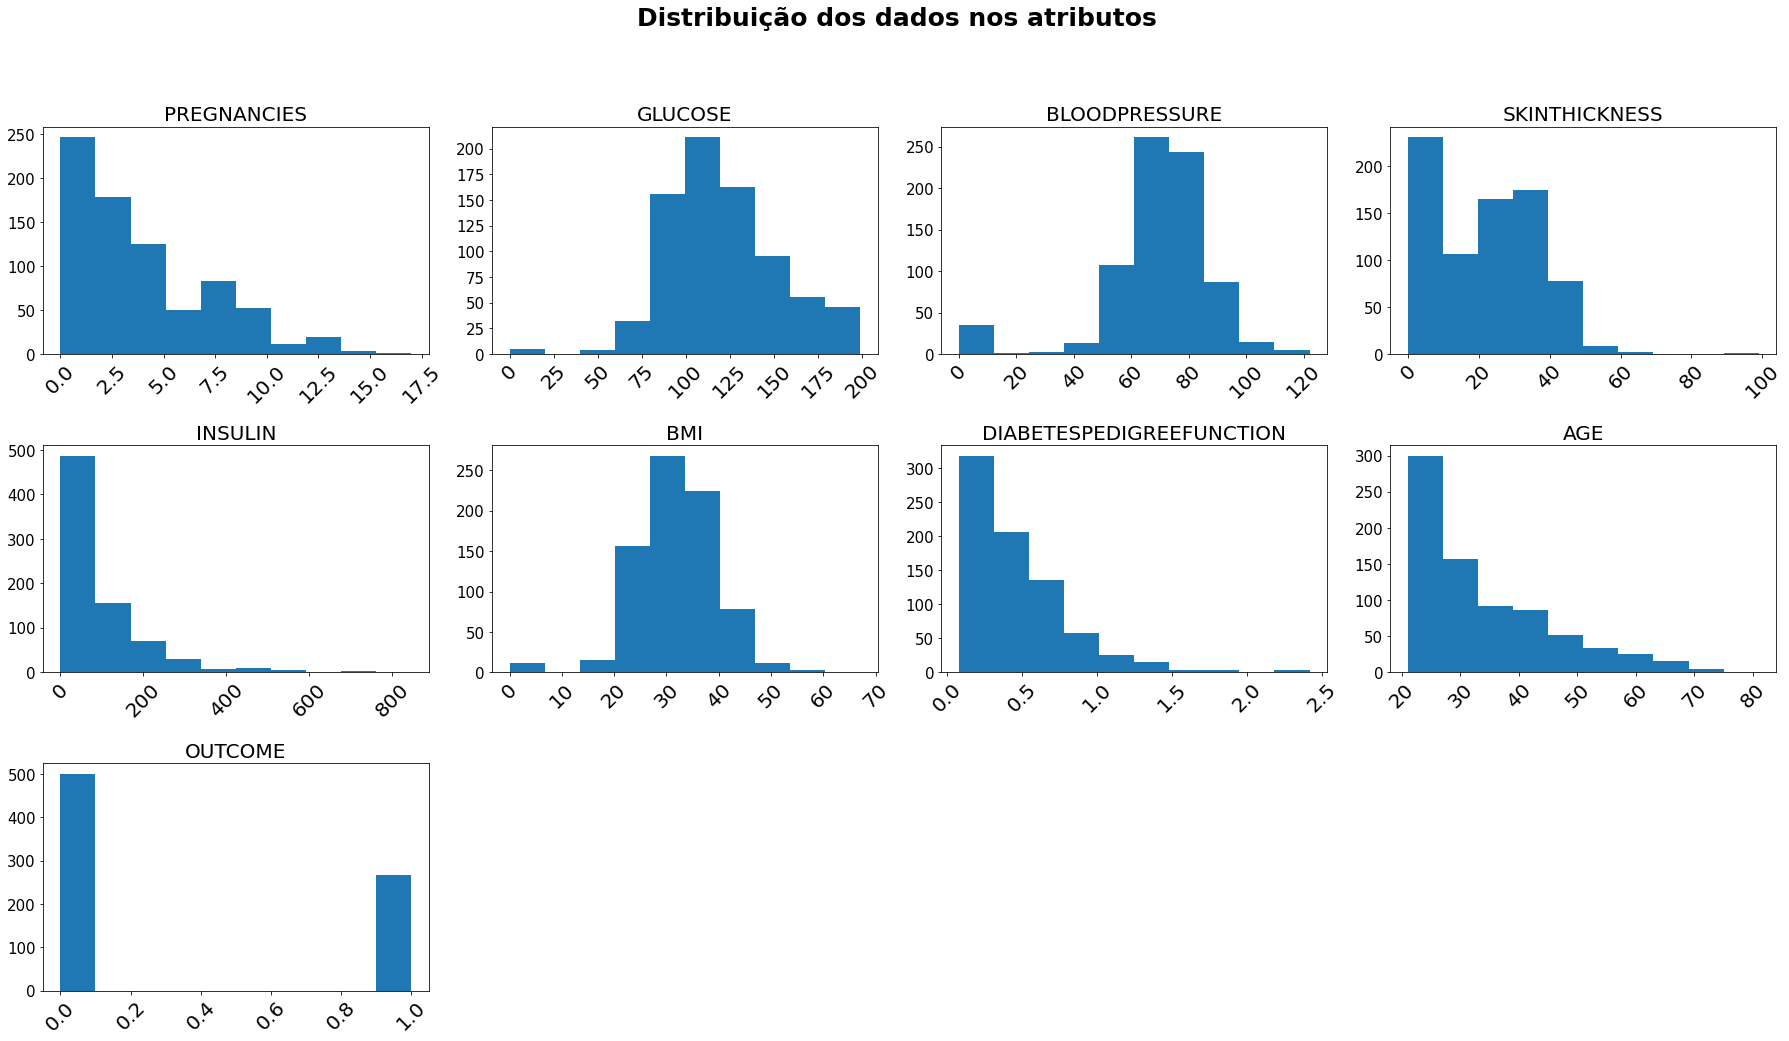

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25,15))     # tamanho da figura

title_y = fig.suptitle('Distribuição dos dados nos atributos',
                      fontsize = 25, 
                      fontweight = 'bold',
                      verticalalignment = 'center')

for col, num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3, 4, num)
    ax.hist(df.toPandas()[col])
    # plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation = 45, fontsize = 20)
    plt.yticks(fontsize = 15)
    plt.title(col.upper(),fontsize = 20)

plt.tight_layout()
title_y.set_y(0.95)

fig.subplots_adjust(top = 0.85,hspace = 0.4)

plt.show();

**Verificando se o conjunto de dados contém valores nulos**

In [24]:
# from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import *

df.select([count(when(isnan(c), c))\
           .alias(c) for c in df.columns])\
           .toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,0,0,0,0,0,0,0,0


> Não temos valores nulos.

**Funções definidas pelo usuário (UDF)**

Podemos querer fazer várias transformações em nossos dados. Uma função definida pelo usuário (UDF) é uma função fornecida pelo usuário em momentos em que as funções integradas não são capazes de fazer o trabalho necessário. 

Podemos usar nossos `UDF's` para manipulação de dados. 

**a) alterar o nome da coluna e converter a variável de destino (OutCome)**

Vamos alterar os valores da variavel de 0 para “Não” e de 1 para “Sim”. Usaremos a função `udf()` para alterar o nome e os valores da variável de destino.

In [25]:
df.select('Outcome').show(5)

+-------+
|Outcome|
+-------+
|      1|
|      0|
|      1|
|      0|
|      1|
+-------+
only showing top 5 rows



In [26]:
# from pyspark.sql.functions import udf
target_udf = udf(lambda y: 'No' if y == 0 else 'yes', StringType())

df = df.withColumn('Diabetes', target_udf('OutCome')).drop('OutCome')

In [27]:
df.printSchema()

root
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Diabetes: string (nullable = true)



> Alteramos o nome da coluna e o tipo de dados desta coluna para "string".

**b) criando uma nova coluna - "Age_groups"**

Nosso objetivo é criar grupos de acordo com faixas etárias com a funcão `udf`. 

Porém antes de tudo, iremos criar uma função para separar as faixas de idade conforme nosso interesse e, para depois aplica-la e realizar a separação das faixas de idades. E por fim, criaremos um novo atributo com as faixas de idade e agregando esse novo recurso no conjunto de dados.

In [28]:
def udf_multiple(age):
      if (age <= 25):
        return 'under 25'
      elif (age >= 25 and age <= 35):
        return 'between 25 and 35'
      elif (age > 35 and age < 50):
        return 'between 36 and 49'
      elif (age >= 50):
        return 'over 50'
      else: return 'N/A'

age_udf = udf(udf_multiple)

df = df.withColumn('Age_udf', age_udf('Age'))

In [29]:
df.select('Age_udf').toPandas().nunique()

Age_udf    4
dtype: int64

**Função da janela (window) - Distribuição de grupos de idade**


Podemos usar as funções “groupBy” e “Window” para ver a distribuição da glicose por faixa etária. A janela nos permite ver a porcentagem de cada grupo de idade no conjunto de dados total.

In [30]:
from pyspark.sql import functions as F
# from pyspark.sql.functions import rank,sum,col
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

table = df.select(['Age_udf', 'Glucose']).\
    groupBy('Age_udf').\
        agg(F.count('Glucose').alias('User_COUNT'),
            F.mean('Glucose').alias('Glucose_AVG'),
            F.min('Glucose').alias('Glucose_MIN'),
            F.max('Glucose').alias('Glucose_Max')).\
        withColumn('Total', sum(col('User_COUNT')).over(window)).\
        withColumn('Percent', col('User_COUNT') * 100 / col('Total')).\
        drop(col('Total')).sort(desc('Percent'))

In [31]:
table.show()

+-----------------+----------+------------------+-----------+-----------+------------------+
|          Age_udf|User_COUNT|       Glucose_AVG|Glucose_MIN|Glucose_Max|           Percent|
+-----------------+----------+------------------+-----------+-----------+------------------+
|         under 25|       267|110.71910112359551|          0|        199|         34.765625|
|between 25 and 35|       231|121.67099567099567|         71|        198|         30.078125|
|between 36 and 49|       181|125.74033149171271|          0|        197|23.567708333333332|
|          over 50|        89| 139.5505617977528|         57|        197|11.588541666666666|
+-----------------+----------+------------------+-----------+-----------+------------------+



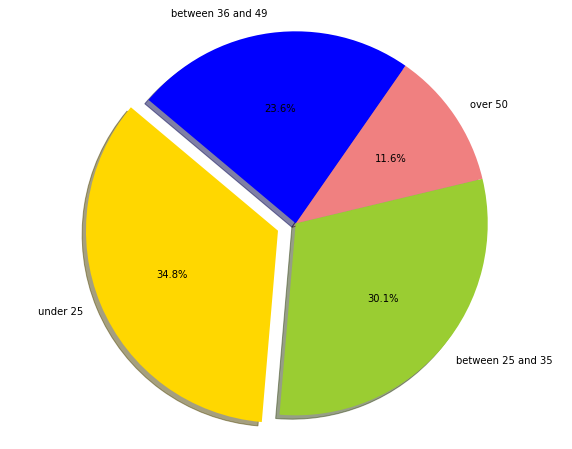

In [32]:
# plotando o gráfico de "pie"
labels = list(table.select('Age_udf').distinct().toPandas()['Age_udf'])
sizes =  list(table.select('Percent').distinct().toPandas()['Percent'])

colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red']
explode = (0.1, 0.0, 0 ,0.0 ) 

plt.figure(figsize = (10,8))
plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 140)

plt.axis('equal')
plt.show();

**Correlação de Pearson**

Podemos usar a biblioteca de estatísticas do PySpark para determinar se há uma alta correlação entre nossos dados. Em primeiro lugar, determinamos as colunas numéricas e fazemos uma lista delas no dataframe "df_corr".

In [33]:
numeric_features = [t[0] for t in df.dtypes if t[1] != 'string']

numeric_features_df = df.select(numeric_features)
numeric_features_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [34]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [35]:
col_names = numeric_features_df.columns
features = numeric_features_df.rdd.map(lambda row: row[0:])

corr_mat  =Statistics.corr(features, method = 'pearson')
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

corr_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


> Utitizando a _correlaço de Pearson_ entre as variáveis numéricas. Podemos ver, que a correlação mais alta é `~0,44`, entre **Insulina e Espessura da Pele**. É óbvio que não existem variáveis ​​numéricas altamente correlacionadas. 

Porém, iremos manter todos os atributos para aplicação do modelo.

In [36]:
df = df.drop('Age')

In [37]:
df.show(4)

+-----------+-------+-------------+-------------+-------+----+------------------------+--------+-----------------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Diabetes|          Age_udf|
+-----------+-------+-------------+-------------+-------+----+------------------------+--------+-----------------+
|          6|    148|           72|           35|      0|33.6|                   0.627|     yes|          over 50|
|          1|     85|           66|           29|      0|26.6|                   0.351|      No|between 25 and 35|
|          8|    183|           64|            0|      0|23.3|                   0.672|     yes|between 25 and 35|
|          1|     89|           66|           23|     94|28.1|                   0.167|      No|         under 25|
+-----------+-------+-------------+-------------+-------+----+------------------------+--------+-----------------+
only showing top 4 rows



## **Preparando os dados para modelagem**

Em primeiro lugar, vamos aplicar 5 transformadores/estimadores importantes da biblioteca `pyspark.ml` antes de começar a construir o modelo. São eles:

- StringIndexer
- OneHotEncoderEstimator
- VectorAssembler
- LabelIndexer
- StandardScaler

Após aplicá-los, os dados estarão prontos para a construção de um modelo.

In [38]:
df2 = df
df3 = df

### **1º método**

**StringIndexer**

_StringIndexer_ converte uma única coluna em uma coluna de índice. StringIndexer simplesmente substitui cada categoria por um número. Os valores mais frequentes obtêm o primeiro valor de índice (0.0). 

In [39]:
from pyspark.ml.feature import StringIndexer

In [40]:
stringIndexer = StringIndexer()\
    .setInputCol ('Age_udf')\
    .setOutputCol ('Age_udfIdx')

Age_udfIndex_model = stringIndexer.fit(df2)

Age_udfIndex_df = Age_udfIndex_model.transform(df2)
Age_udfIndex_df.toPandas().head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Diabetes,Age_udf,Age_udfIdx
0,6,148,72,35,0,33.6,0.627,yes,over 50,3.0
1,1,85,66,29,0,26.6,0.351,No,between 25 and 35,1.0
2,8,183,64,0,0,23.3,0.672,yes,between 25 and 35,1.0
3,1,89,66,23,94,28.1,0.167,No,under 25,0.0
4,0,137,40,35,168,43.1,2.288,yes,between 25 and 35,1.0
5,5,116,74,0,0,25.6,0.201,No,between 25 and 35,1.0
6,3,78,50,32,88,31.0,0.248,yes,between 25 and 35,1.0
7,10,115,0,0,0,35.3,0.134,No,between 25 and 35,1.0
8,2,197,70,45,543,30.5,0.158,yes,over 50,3.0
9,8,125,96,0,0,0.0,0.232,yes,over 50,3.0


> Como podemos ver, “under 25” assumiu o valor de índice de "0.0". O grupo “over 50” tem a menor população em nosso conjunto de dados e, por isso recebe o maior valor de índice, nesse caso "3.0".

**OneHotEncoderEstimator**

Usamos “OneHotEncoderEstimator” para converter variáveis ​​categóricas em `SparseVectors` binários.
Com OneHotEncoder, criamos uma variável fictícia para cada valor em colunas categóricas e atribuímos a ela um valor 1 ou 0. Este método produz resultados diferentes com pandas. Se fizermos essa transformação no Pandas, 4 novas colunas serão produzidas para quatro grupos. No entanto, 3 colunas são produzidas no Spark. Se nossa faixa etária for "under 50+", _Age_encoded_ será (0.0,0.0,0.0)

In [41]:
from pyspark.ml.feature import OneHotEncoder

In [42]:
encoder = OneHotEncoder()\
    .setInputCols (['Age_udfIdx'])\
    .setOutputCols (['Age_encoded'])

encoder_model = encoder.fit(Age_udfIndex_df)

encoder_df = encoder_model.transform(Age_udfIndex_df)
encoder_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Diabetes,Age_udf,Age_udfIdx,Age_encoded
0,6,148,72,35,0,33.6,0.627,yes,over 50,3.0,"(0.0, 0.0, 0.0)"
1,1,85,66,29,0,26.6,0.351,No,between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
2,8,183,64,0,0,23.3,0.672,yes,between 25 and 35,1.0,"(0.0, 1.0, 0.0)"
3,1,89,66,23,94,28.1,0.167,No,under 25,0.0,"(1.0, 0.0, 0.0)"
4,0,137,40,35,168,43.1,2.288,yes,between 25 and 35,1.0,"(0.0, 1.0, 0.0)"


**VectorAssembler**

Transforme todos os recursos em um vetor usando VectorAssembler.

In [43]:
import pandas as pd

pd.set_option('display.max_colwidth', 80)
pd.set_option('max_columns', 12)

In [44]:
from pyspark.ml.feature import VectorAssembler

In [45]:
assembler = VectorAssembler()\
    .setInputCols (['Age_encoded', 'Pregnancies', 'Glucose',
                    'BloodPressure', 'SkinThickness',\
                    'Insulin', 'BMI', 'DiabetesPedigreeFunction'])\
    .setOutputCol ('vectorized_feats')
        
assembler_df = assembler.transform(encoder_df)

assembler_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Diabetes,Age_udf,Age_udfIdx,Age_encoded,vectorized_feats
0,6,148,72,35,0,33.6,0.627,yes,over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35.0, 0.0, 33.6, 0.627]"
1,1,85,66,29,0,26.6,0.351,No,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29.0, 0.0, 26.6, 0.351]"
2,8,183,64,0,0,23.3,0.672,yes,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0.0, 0.0, 23.3, 0.672]"
3,1,89,66,23,94,28.1,0.167,No,under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23.0, 94.0, 28.1, 0.167]"
4,0,137,40,35,168,43.1,2.288,yes,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35.0, 168.0, 43.1, 2.288]"


**LabelIndexer**

Convertendo o rótulo em índices de rótulo usando StringIndexer da coluna alvo, `Diabetes`.
- “No” será atribuído com o valor de “0.0” e, 
- “yes” com o valor de “1.0”.

In [46]:
label_indexer = StringIndexer()\
    .setInputCol ('Diabetes')\
    .setOutputCol ('label')

label_indexer_model = label_indexer.fit(assembler_df)
label_indexer_df = label_indexer_model.transform(assembler_df)

label_indexer_df.select('Diabetes', 'label').toPandas().head()

,Diabetes,label
0,yes,1.0
1,No,0.0
2,yes,1.0
3,No,0.0
4,yes,1.0


**StandardScaler**

A padronização de um conjunto de dados é um requisito comum para muitos estimadores de aprendizado de máquina. <br>Quando não dada devida atenção para essa situação os modelos podem se comportar mal se os recursos individuais não se parecerem com dados mais ou menos normalmente distribuídos (por exemplo, Gaussiano com média 0 e variância unitária).<br>
O StandardScaler padroniza os recursos removendo a média e escalando para a variação da unidade.

In [47]:
from pyspark.ml.feature import StandardScaler

In [48]:
scaler = StandardScaler()\
    .setInputCol ('vectorized_feats')\
    .setOutputCol ('features')
        
scaler_model = scaler.fit(label_indexer_df)
scaler_df = scaler_model.transform(label_indexer_df)

pd.set_option('display.max_colwidth', 40)
scaler_df.select('vectorized_feats', 'features').toPandas().head(5)

,vectorized_feats,features
0,"[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35...","[0.0, 0.0, 0.0, 1.7806383732194306, ..."
1,"[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29....","[0.0, 2.1791401333367157, 0.0, 0.296..."
2,"[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0....","[0.0, 2.1791401333367157, 0.0, 2.374..."
3,"[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....","[2.098474993842542, 0.0, 0.0, 0.2967..."
4,"[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...","[0.0, 2.1791401333367157, 0.0, 0.0, ..."


### **2º método**

**Criando 5 transformadores/estimadores e aplicando todos em um pipeline**

**Pipeline de modelo**

Usamos pipeline para encadear vários transformadores e estimadores para especificar nosso fluxo de trabalho de aprendizado de máquina. Os estágios de um pipeline são especificados como uma matriz ordenada.

In [49]:
from pyspark.ml import Pipeline

In [50]:
pipeline_stages = Pipeline()\
    .setStages([stringIndexer, encoder, assembler, label_indexer, scaler])

pipeline_model = pipeline_stages.fit(df3)
pipeline_df = pipeline_model.transform(df3)

In [51]:
pipeline_df.toPandas().head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,...,Age_udf,Age_udfIdx,Age_encoded,vectorized_feats,label,features
0,6,148,72,35,0,33.6,...,over 50,3.0,"(0.0, 0.0, 0.0)","[0.0, 0.0, 0.0, 6.0, 148.0, 72.0, 35...",1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, ..."
1,1,85,66,29,0,26.6,...,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 1.0, 85.0, 66.0, 29....",0.0,"[0.0, 2.1791401333367157, 0.0, 0.296..."
2,8,183,64,0,0,23.3,...,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 8.0, 183.0, 64.0, 0....",1.0,"[0.0, 2.1791401333367157, 0.0, 2.374..."
3,1,89,66,23,94,28.1,...,under 25,0.0,"(1.0, 0.0, 0.0)","[1.0, 0.0, 0.0, 1.0, 89.0, 66.0, 23....",0.0,"[2.098474993842542, 0.0, 0.0, 0.2967..."
4,0,137,40,35,168,43.1,...,between 25 and 35,1.0,"(0.0, 1.0, 0.0)","[0.0, 1.0, 0.0, 0.0, 137.0, 40.0, 35...",1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, ..."


### **3º método**


**Uma maneira mais fácil de construir pipeline**

O código a seguir foi retirado do [site oficial](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html) do [databricks](https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html). <br>Em primeiro lugar, determinamos colunas categóricas. Em seguida, ele indexa cada coluna categórica usando o `StringIndexer`. Depois disso, ele converte as categorias indexadas em variáveis ​​codificadas _one-hot_. <br>A saída resultante tem os **vetores binários** anexados ao final de cada linha. Usamos o StringIndexer novamente para codificar nossos rótulos para índices de rótulos. Em seguida, usamos o `VectorAssembler` para combinar todas as colunas de recursos em uma única coluna de vetor. <br>Como uma etapa final, usamos `StandardScaler` para distribuir nossos recursos normalmente.

In [52]:
categoricalColumns = ['Age_udf']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols = [stringIndexer.getOutputCol()], outputCols = [categoricalCol + 'classVec'])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'Diabetes', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
               'Insulin', 'BMI', 'DiabetesPedigreeFunction']
               
assemblerInputs = [c + 'classVec' for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'vectorized_feats')
stages += [assembler]

scaler = StandardScaler(inputCol = 'vectorized_feats', outputCol = 'features')
stages += [scaler]

In [53]:
cols = df.columns

In [54]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Diabetes',
 'Age_udf']

In [55]:
stages

[StringIndexer_08452502d6da,
 OneHotEncoder_ed7c8581a13d,
 StringIndexer_e842fdaa5123,
 VectorAssembler_de158b96c135,
 StandardScaler_fa51d0ce2e36]

In [56]:
cols = df.columns

pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- Pregnancies: integer (nullable = true)
 |-- Glucose: integer (nullable = true)
 |-- BloodPressure: integer (nullable = true)
 |-- SkinThickness: integer (nullable = true)
 |-- Insulin: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- DiabetesPedigreeFunction: double (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Age_udf: string (nullable = true)



In [57]:
df.toPandas().head()

,label,features,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Diabetes,Age_udf
0,1.0,"[0.0, 0.0, 0.0, 1.7806383732194306, ...",6,148,72,35,0,33.6,0.627,yes,over 50
1,0.0,"[0.0, 2.1791401333367157, 0.0, 0.296...",1,85,66,29,0,26.6,0.351,No,between 25 and 35
2,1.0,"[0.0, 2.1791401333367157, 0.0, 2.374...",8,183,64,0,0,23.3,0.672,yes,between 25 and 35
3,0.0,"[2.098474993842542, 0.0, 0.0, 0.2967...",1,89,66,23,94,28.1,0.167,No,under 25
4,1.0,"[0.0, 2.1791401333367157, 0.0, 0.0, ...",0,137,40,35,168,43.1,2.288,yes,between 25 and 35


## **Divisão do conjunto de dados em treino e teste**

Temos total de 768 observações presente no conjunto de dados e, iremos dividir o conjunto de dados, 70% para treinamento do modelo e o restante, 30% para teste.

In [58]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)

print('Dados para treinamento: ' + str(train.count()))
print('Dados para teste: ' + str(test.count()))

Dados para treinamento: 547
Dados para teste: 221


In [59]:
train.groupby('Diabetes').count().show()

+--------+-----+
|Diabetes|count|
+--------+-----+
|      No|  349|
|     yes|  198|
+--------+-----+



**Treinamento de modelo**

In [60]:
from pyspark.ml.classification import LogisticRegression

In [61]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)

lrModel = lr.fit(train)
predictions = lrModel.transform(test)

#predictions_train = lrModel.transform(train)
predictions.select('label', 'features',  'rawPrediction', 'prediction', 'probability').toPandas().head(10)

,label,features,rawPrediction,prediction,probability
0,0.0,"(2.098474993842542, 0.0, 0.0, 0.5935...","[0.8259323736971699, -0.825932373697...",0.0,"[0.6954941653271036, 0.3045058346728..."
1,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[1.8226685930692328, -1.822668593069...",0.0,"[0.8608860290385492, 0.1391139709614..."
2,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[1.7771792394516923, -1.777179239451...",0.0,"[0.8553482095433572, 0.1446517904566..."
3,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 3...","[2.207661377035781, -2.207661377035781]",0.0,"[0.9009353984556185, 0.0990646015443..."
4,0.0,"(2.098474993842542, 0.0, 0.0, 0.0, 2...","[0.8985607781927555, -0.898560778192...",0.0,"[0.7106536523312756, 0.2893463476687..."
5,0.0,"(0.0, 2.1791401333367157, 0.0, 1.780...","[-0.3260038412217334, 0.326003841221...",1.0,"[0.4192132666380051, 0.5807867333619..."
6,0.0,"(0.0, 2.1791401333367157, 0.0, 0.0, ...","[1.1201506450479144, -1.120150645047...",0.0,"[0.7540166584893252, 0.2459833415106..."
7,0.0,"(0.0, 0.0, 2.354615257971737, 0.0, 3...","[0.7187753643403545, -0.718775364340...",0.0,"[0.6723372869643282, 0.3276627130356..."
8,0.0,"(0.0, 0.0, 2.354615257971737, 0.0, 3...","[-1.0336454139944904, 1.033645413994...",1.0,"[0.26237797526141954, 0.737622024738..."
9,0.0,"(0.0, 0.0, 0.0, 0.29677306220323846,...","[0.2773649406036499, -0.277364940603...",0.0,"[0.5689000859856598, 0.4310999140143..."


## **Avaliação do modelo**

Podemos usar `BinaryClassificationEvaluator` para avaliar nosso modelo.

Observe que a métrica padrão para o _BinaryClassificationEvaluator_ é `areaUnderROC`.

_ROC_ é uma curva de probabilidade e _AUC_ representa o grau ou medida de separabilidade. 
- ROC informa o quanto o modelo é capaz de distinguir entre as classes. 
- Quanto maior a AUC, melhor o modelo distingue entre pacientes com diabetes e sem diabetes.

In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Teste da área sobre ROC:', evaluator.evaluate(predictions))

Teste da área sobre ROC: 0.7013245033112583


**Precisão do modelo**


In [83]:
import itertools

class_names=[1.0 ,0.0]

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Matriz de confusão',
                          cmap = plt.cm.Blues):
    
    '''
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize = True`.
    '''

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print('Matriz de confusão [normalizada]\n')
    else:
        print('Matriz de confusão [sem normalização]\n')

    print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('Rótulo verdadeiro - True label')
    plt.xlabel('Rótulo previsto - Predicted label')

In [84]:
from sklearn.metrics import confusion_matrix
import numpy as np

Matriz de confusão [sem normalização]

[[ 19  51]
 [  4 147]]




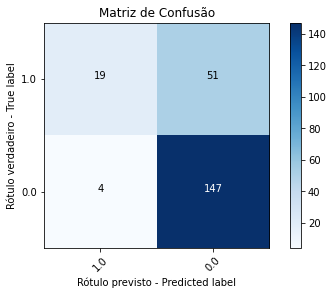

In [85]:
y_true = predictions.select('label')
y_true = y_true.toPandas()

y_pred = predictions.select('prediction')
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels = class_names)

# matriz de confusão
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title = 'Matriz de Confusão')
print('\n')
plt.show();

**Acurácia do modelo**

In [86]:
accuracy = predictions.filter(predictions.label == predictions.prediction)\
    .count() / float(predictions.count())
    
print('Accuracy: ', accuracy)

Accuracy:  0.751131221719457


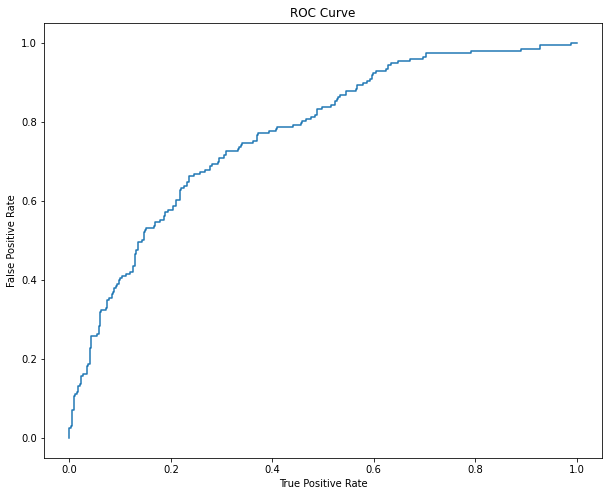


Training set areaUnderROC: 0.7712077798037666


In [87]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()

plt.figure(figsize = (10,8))
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show();

print('\nTraining set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## **Validação cruzada e ajuste de parâmetro**

Agora vamos tentar ajustar o modelo com o `ParamGridBuilder` e o `CrossValidator`.

Se você não tiver certeza de quais parâmetros estão disponíveis para ajuste, você pode usar `explainParams()` para imprimir uma lista de todos os parâmetros e suas definições.

In [88]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# criando o ParamGrid para validação cruzada
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])    # parâmetro de regularização
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # parâmetro de rede elástica (Ridge = 0)
             .addGrid(lr.maxIter, [1, 5, 10])   # número de iterações
             .build())

cv = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid, 
                    evaluator = evaluator, numFolds = 5)

cvModel = cv.fit(train)

> Como indicamos 3 valores para regParam (parâmetro de regularização), 3 valores para maxIter (número de iterações) e 3 valores para elasticNetParam (parâmetro de rede elástica), esta grade terá 3 x 3 x 3 = 27 configurações de parâmetro para CrossValidator escolher. Criamos o validador cruzado de 5 etapas.

## **Melhor Desempenho de Modelo**

## Best Model Performance

In [69]:
# avaliando o melhor modelo
predictions = cvModel.transform(test)
print('Melhor área de teste do modelo em ROC:', evaluator.evaluate(predictions))

Melhor área de teste do modelo em ROC: 0.7812677388836319


## **Pesos de recursos do melhor modelo**

In [70]:
cvModel.bestModel

LogisticRegressionModel: uid=LogisticRegression_67e24faaed16, numClasses=2, numFeatures=10

In [71]:
from pyspark.sql import SQLContext

In [72]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [73]:
weights = cvModel.bestModel.coefficients

weights = [(float(w),) for w in weights]
weightsDF = sqlContext.createDataFrame(weights, ['Peso do recurso para predição do modelo'])

weightsDF.toPandas().head(10)

,Peso do recurso para predição do modelo
0,-0.159237
1,0.008193
2,0.105965
3,0.088691
4,0.276403
5,-0.015411
6,0.016917
7,0.066750
8,0.185800
9,0.103407


## **Parâmetros do melhor modelo**

In [74]:
best_model = cvModel.bestModel

In [75]:
print('Melhor parâmetro (regParam): ', best_model._java_obj.getRegParam())
print('Melhor parâmetro (MaxIter): ', best_model._java_obj.getMaxIter())
print('Melhor parâmetro (elasticNetParam): ', best_model._java_obj.getElasticNetParam())

Melhor parâmetro (regParam):  0.5
Melhor parâmetro (MaxIter):  10
Melhor parâmetro (elasticNetParam):  0.0


In [76]:
best_model.explainParams().split('\n')

['aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)',
 'elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)',
 'family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)',
 'featuresCol: features column name. (default: features, current: features)',
 'fitIntercept: whether to fit an intercept term. (default: True)',
 'labelCol: label column name. (default: label, current: label)',
 'lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)',
 'lowerBoundsOnIntercepts: The lower bounds on intercepts if fitti